<a href="https://colab.research.google.com/github/vandana10/deeplearning-using-pytorch/blob/main/pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Computer vision


## 0. COmputer vision libraries in PyTorch

* 'torchvision' - base domain library for PyTorch CV
* torchvision.datasets - gets datasets and data loading functions for CV
* torchvision.models - get predicted CV models that you can leverage
* torchvision.tranformers - functions for manipulating your vison data (images) to be suitable for use with an ML
* torch.utils.data.Dataset - Base dataset
* torch.utils.data.DataLoader -  Creates a python iterable over a dataset

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.8.0+cu126
0.23.0+cu126


## 1. Getting a datset

The dataset we'll be using is fashion mnist from torchvision.datasets

In [2]:
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
#See the first training example
train_data[0][0].shape

torch.Size([1, 28, 28])

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### 1.2 Visualize data

Image size: torch.Size([1, 28, 28])
Label: 9, Class: Ankle boot


Text(0.5, 1.0, 'Ankle boot')

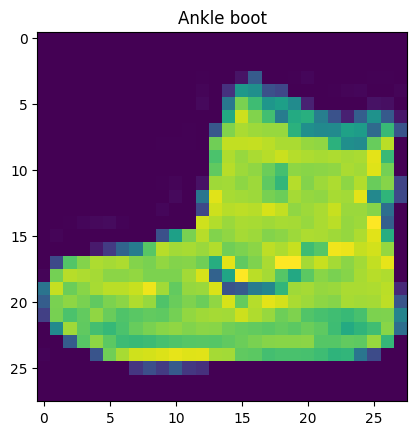

In [8]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image size: {image.shape}")
print(f"Label: {label}, Class: {class_names[label]}")
plt.imshow(image.squeeze())
plt.title(class_names[label])

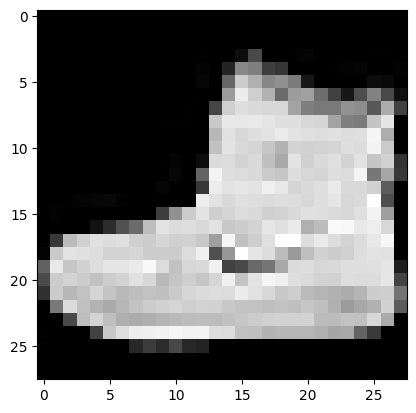

In [9]:
plt.imshow(image.squeeze(), cmap="gray")

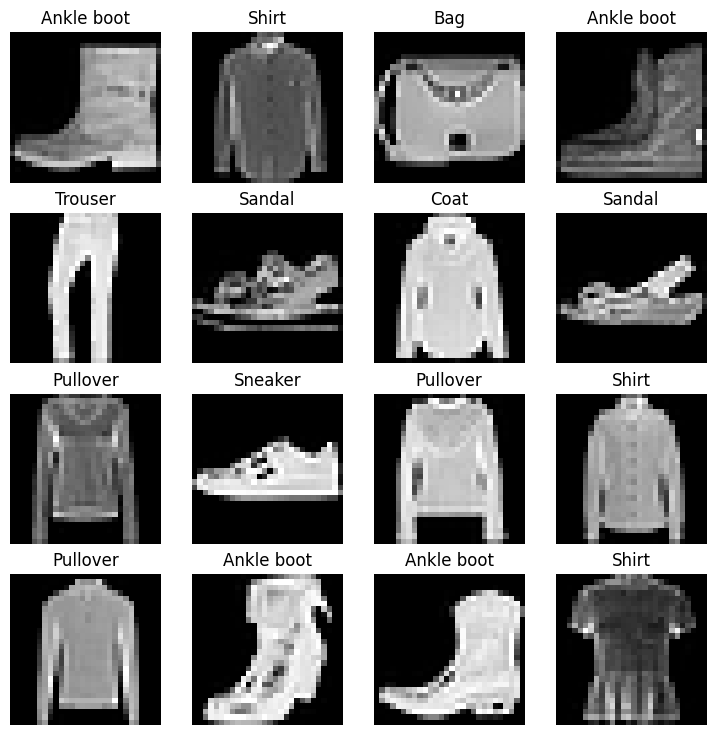

In [10]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

Do you think these clothing could be modeeled with oure linear lines?


## 2. Prepare dataloader

as of now,data is in from of PyTroch datasets

dataLoader turns dataset into a iterable, ie turn data into batches(mini batches)

why?
1. More computationally efficient, looking at 60000 images at onceis difficult, so we break it down to 32 images at a time(batch size of 32)
2. Gives our NN more chances to update gradients per epoch

In [11]:
from torch.utils.data import DataLoader

#Set up batchsize
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x79a32930a630>,
 <torch.utils.data.dataloader.DataLoader at 0x79a328ec6270>)

In [12]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x79a32930a630>, <torch.utils.data.dataloader.DataLoader object at 0x79a328ec6270>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, Class: Bag


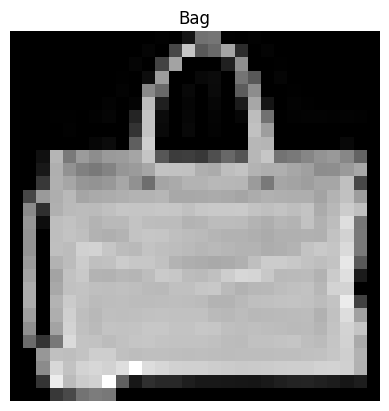

In [14]:
#Show a sample
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, Class: {class_names[label]}")


## 3. Model 0: build a baseline model

Start with a baseline model
It's a simple model you will try and imprive upon subsequent models/experiments

In other words: start simply and add complexity wheh nessary


In [15]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flatten: {x.shape}") # color channel, height, width
print(f"Shape after flatten: {output.shape}") # color channel, height*width

Shape before flatten: torch.Size([1, 28, 28])
Shape after flatten: torch.Size([1, 784])


In [16]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784, # this is 28*28
                              hidden_units=10,
                              output_shape=len(class_names))

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.randn([1,1, 28, 28])
dummy_x.shape
model_0(dummy_x)

tensor([[-0.2228,  0.1477,  0.3137, -0.3110, -0.3713,  0.0156,  0.4363,  0.1060,
         -0.1604, -0.4388]], grad_fn=<AddmmBackward0>)

In [19]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.2 Set up loss , optimiser, and evaluation metrics

*Loss function: nn.CrossEntroyLoss()
* Optimiser: torch.optim.SGD()
* Evaluation metrics: accuracy

In [20]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists


In [21]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


### 3.2 Create a func to time our experiments

ML is very experimental

Two things you'll often want to track you:
1. Model's performance(loss and acc values etc)
2. How fast it runs

In [22]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def print_train_time(start: float,
                      end: float,
                      device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [23]:
start_time = timer()
#some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device=None)

Train time on None: 0.000 seconds


5.8151999837718904e-05

In [24]:
# Uptohere: 3.3 Creating a training loop and testing loop on batches of data
# Highlight that the optimiser will update a model's parameters once per batch rather than once per epoch

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epoch
2. Loop through training batches, perform training steps, calc the train loss per batch
3. Loop through testing batches, perform training steps, calc the test loss per batch
4. Print out whats happeneing
5. Time it all

In [25]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"epoch: {epoch}")

  train_loss = 0

  #Add a loop to loop through batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    if(batch % 400 == 0):
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

    optimizer.step()

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)


  print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

train_time_end_on_cpu = timer()


  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04
epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20
epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43


## 4. Make predictions and get model ) results

In [26]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

#Calc model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 6. building a model with non-linearity



In [27]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units_one: int,
               hidden_units_two: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units_one),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units_one,
                  out_features=hidden_units_two),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units_two,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [28]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                               hidden_units_one=10,
                               hidden_units_two=10,
                               output_shape=len(class_names))

model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
  )
)

In [29]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [30]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn):
  """Performs training step"""
  train_loss, train_acc = 0, 0

  #Add a loop to loop through batches
  for batch, (X,y) in enumerate(data_loader):
    model.train()

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_acc += acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [31]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn):
  """Performs testing step"""
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")




In [32]:
torch.manual_seed(42)


from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
  test_step(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn)

train_time_end_on_cpu = timer()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.92836 | Train acc: 66.64%
Test loss: 0.70984 | Test acc: 73.43%

Epoch: 1
---------
Train loss: 0.68567 | Train acc: 74.75%
Test loss: 0.70210 | Test acc: 73.93%

Epoch: 2
---------
Train loss: 0.49993 | Train acc: 82.03%
Test loss: 0.49066 | Test acc: 83.11%



In [33]:
#get model_1 result dictionaryu

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.49066323041915894,
 'model_acc': 83.1070287539936}

In [34]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Model 2: Building a CNN


In [42]:
#Create a CNN
class FashionMNISTModelV2(nn.Module):
  """
  Model arch that replicates the TinyVGG
  model from CCN explanier website"""
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),# values we can set ourselves in our NN's are called Hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                    stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units,stride=1, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units,stride=1, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, #there's a trick to calc this
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_21:{x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2:{x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier:{x.shape}")
    return x


In [43]:
image.shape

torch.Size([1, 28, 28])

In [44]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))



### 7.1 Stepping through nn.Conv2d

In [45]:
torch.manual_seed(42)

#Create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]
print(f"image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")


image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])


In [46]:
torch.manual_seed(42)
#Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels = 10,
                       kernel_size=(3,3),
                       stride=1,
                       padding=1)
#Pass the data through the conv layer
conv_output = conv_layer(test_image)
conv_output.shape


torch.Size([10, 64, 64])

### 7.2 Stepping through nn.Maxpool2d

In [47]:
test_image.shape

torch.Size([3, 64, 64])

In [48]:
print(f"Single image shape: {test_image.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

#Pass data through conv layer
test_image_through_conv = conv_layer(test_image)
print(f"Single image shape: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Single image shape: {test_image_through_conv_and_max_pool.shape}")

Single image shape: torch.Size([3, 64, 64])
Single image shape: torch.Size([10, 64, 64])
Single image shape: torch.Size([10, 32, 32])


In [49]:
torch.manual_seed(42)

#create a random tensor with a similar no of dimensions to our images
random_tensor = torch.randn(size=(1,1,2,2))
print(f"\n Random  tensor:\n {random_tensor}")
print(f"Random  tensor shape: {random_tensor.shape}")


max_pool_layer= nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f"\n Max pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")



 Random  tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random  tensor shape: torch.Size([1, 1, 2, 2])

 Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


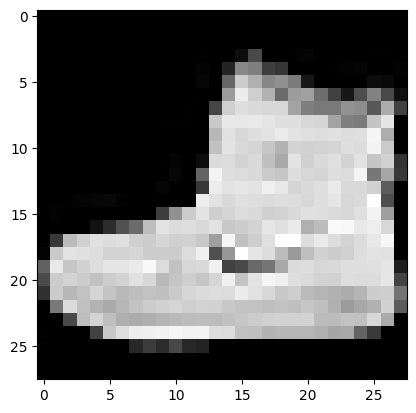

In [50]:
plt.imshow(image.squeeze(), cmap="gray")

In [51]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

### 7.3 Setup loss fn and optimizer

In [52]:
#Set up lossFn/Optimiser

from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


### 7.4 Training and testing model_2 using train and test functions

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
  test_step(model=model_2,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn)

train_time_end_on_cpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59518 | Train acc: 78.38%
Test loss: 0.39500 | Test acc: 85.99%

Epoch: 1
---------
Train loss: 0.36536 | Train acc: 86.90%
Test loss: 0.35244 | Test acc: 86.91%

Epoch: 2
---------
Train loss: 0.32588 | Train acc: 88.13%


In [56]:
#Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

### 8. Comparing model results and training time

In [58]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.490663,83.107029
2,FashionMNISTModelV2,0.327190,88.069089


### 9. make and evaluate random predcitions with best model

In [59]:
def make_predictions(model: torch.nn.Module,
                     data: list):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob)

  return torch.stack(pred_probs)



In [60]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [83]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)

#view the first sample shape
test_samples[0].shape


torch.Size([1, 28, 28])

In [84]:
# make predcitions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)
pred_probs

tensor([[7.2208e-06, 2.3361e-06, 4.7868e-06, 1.6791e-05, 3.1357e-06, 8.5480e-03,
         7.6704e-06, 9.1218e-04, 8.1188e-04, 9.8969e-01],
        [1.6009e-05, 1.7970e-05, 1.4202e-03, 1.8855e-06, 9.9307e-01, 2.4557e-07,
         5.4376e-03, 4.7640e-07, 3.5106e-05, 2.9922e-06],
        [2.4299e-02, 2.2057e-03, 2.4537e-01, 8.5882e-03, 1.5849e-02, 9.9908e-05,
         7.0126e-01, 1.9597e-05, 2.2863e-03, 1.5218e-05],
        [2.8215e-05, 2.9023e-06, 1.1169e-05, 9.2122e-06, 2.7005e-06, 5.0164e-03,
         1.3943e-05, 1.8511e-02, 6.8313e-03, 9.6957e-01],
        [2.3214e-07, 2.9765e-07, 1.1336e-06, 2.8285e-05, 5.1587e-07, 1.3557e-03,
         6.6350e-08, 9.9841e-01, 3.3790e-05, 1.7400e-04],
        [9.4124e-01, 5.3894e-06, 1.3340e-04, 2.0038e-03, 9.9376e-06, 1.5996e-07,
         5.6584e-02, 3.7775e-07, 2.1229e-05, 1.7640e-06],
        [2.0840e-04, 1.2963e-03, 3.0094e-04, 1.5695e-04, 9.8844e-01, 9.2883e-06,
         8.8911e-03, 4.7786e-07, 6.9540e-04, 1.8059e-06],
        [9.7569e-01, 5.7717

In [85]:
#convert pred probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 4, 6, 9, 7, 0, 4, 0, 5])

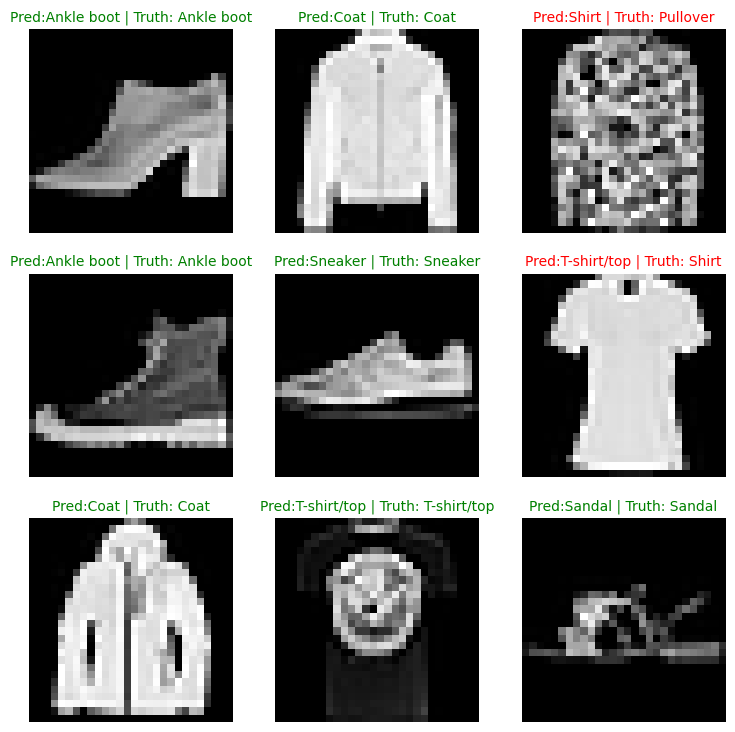

In [86]:
#plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap = "gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred:{pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, color="green")
  else:
    plt.title(title_text, fontsize=10, color="red")
  plt.axis(False)

## 10. Making a confusion matrix for further predcition evaluation

A confusion matrix is a fantastic way of evaluating your classfication models

1. make predictions with our model on the test dataset
2. make  a confusiin matrix 'torchmetrics.ConfusionMatrix
3. Plot the Confusion matrix using mlextend.plotting.plot_confusion_matrix()

In [94]:
import mlxtend
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred)

#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [95]:
len(y_pred_tensor)

10000

In [97]:
try:
  import torchmetrics, mlxtend
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 11.4 MB/s eta 0:00:00


In [99]:
mlxtend.__version__

'0.23.4'

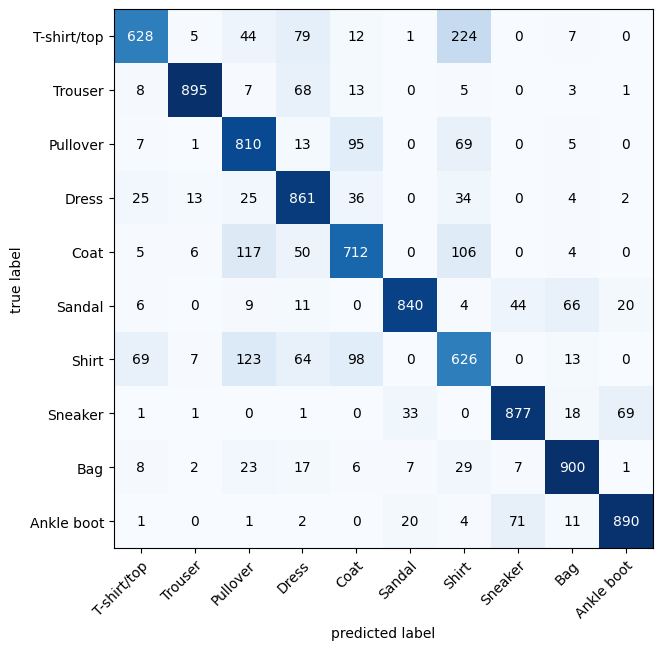

In [102]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds = y_pred_tensor, target = test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                               class_names=class_names,
                               figsize=(10,7))

## 11. Save and load the model

In [105]:
from pathlib import Path
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorchcomputer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH /MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)


saving model to: model/03_pytorchcomputer_vision_model_2.pth


In [107]:
#Create a new insstance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units = 10,
                                     output_shape=len(class_names))

loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_2.eval()

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [108]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

In [110]:
#Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

In [113]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),torch.tensor(loaded_model_2_results["model_loss"]),

              atol = 1e-02)

tensor(True)